# Instancia de Autoevaluación: Entrega de tarea - Presentación de Video grabada obligatorio




En esta instancia de autoevaluación vamos a poner en juego todos los
conocimientos que hemos recorrido juntos en esta clase. Tendremos en
cuenta los tipos de ejercicios que realizamos la teoría que leímos y los
ejemplos que vimos en los diferentes recursos.



Trabajaremos con el dataset disponible en campus el cual contiene los
siguientes datos sobre clientes:
  1. `purchase_freq_month` — frecuencia de compras por mes (escala
  baja a media).
  2. `avg_basket_usd` — ticket/promedio por compra en USD (escala
  media a alta).
  3. `time_on_site_min` — tiempo de permanencia en el sitio (minutos).
  4. `discount_sensitivity` — sensibilidad a descuentos (0 a 1).
  5. `returns_rate` — tasa de devoluciones (0 a 0.8 aprox.).


**Pista:**
algunas variables deberían ser escaladas antes de aplicar K-Means.


Qué se quiere descubrir con K-Means
- **Objetivo**: identificar cuántos segmentos latentes de clientes existen a
partir de sus comportamientos de compra y uso del sitio, sin
etiquetas previas.
- **Qué patrones buscar**:
    - Grupos con frecuencia alta pero ticket bajo y alta sensibilidad
a descuentos.
    - Grupos con frecuencia baja pero ticket alto y baja sensibilidad
(compras esporádicas pero grandes).
    - Grupos con tiempo en sitio y tasa de devoluciones
diferenciados (p. ej., exploran mucho y devuelven más vs.
exploran poco y devuelven menos).

- Cómo validarlo:
    - Comparar k=2..6 usando método del codo para justificar qué
valor de k es razonable.
    - Analizar los centroides por cluster para describir perfiles (p. ej.,
“Cluster 1: alta frecuencia + ticket medio + sensibilidad media,
foco para promociones; Cluster 2: ticket alto + baja
sensibilidad, foco en upselling premium”, etc.).

En esta instancia deberás grabar un video de no más de 5/7 minutos de
duración donde expliques cómo implementamos el modelo de aprendizaje
no supervisado, los patrones que pudiste detectar y qué mejoras pensás
que podríamos hacer al modelo.

Además deberá estar la jupyter notebook en tu repositorio GIT. El link al
video debe estar en el repositorio.

# Segmentación de Clientes con **K-Means**


## Objetivo:



Identificar **segmentos latentes** de clientes a partir de su comportamiento de compras y uso del sitio (aprendizaje **no supervisado**).

**Dataset (columnas):**
1. `purchase_freq_month` — frecuencia de compras por mes (escala baja a media).  
2. `avg_basket_usd` — ticket/promedio por compra en USD (escala media a alta).  
3. `time_on_site_min` — tiempo de permanencia en el sitio (minutos).  
4. `discount_sensitivity` — sensibilidad a descuentos (0 a 1).  
5. `returns_rate` — tasa de devoluciones (0 a 0.8 aprox.).  

**Patrones esperados a detectar (ejemplos):**
- Alta frecuencia **pero** ticket bajo y **alta** sensibilidad a descuentos.  
- Frecuencia **baja** pero ticket **alto** y **baja** sensibilidad (compras esporádicas pero grandes).  
- Diferencias en **tiempo en sitio** y **tasa de devoluciones** (p. ej., exploran mucho y devuelven más vs. exploran poco y devuelven menos).


## 1) Setup, carga de datos y chequeos rápidos


### Librerias


In [114]:
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from pathlib import Path
import joblib


In [115]:
print("Python:", sys.version.split()[0])


df = pd.read_csv("https://raw.githubusercontent.com/GabrielBellesi-edu/AA2A1C-25/main/clase_8/segmentacion_clientes.csv")
print("Forma del dataset:", df.shape)
display(df.head())

# Tipos de datos del dataset
print("\nTipos de datos:")
print(df.dtypes)

# Valores Nulos
print("\nValores nulos por columna:"),print(df.isna().sum())

# Aseguramos tipos numéricos
cols = ["purchase_freq_month","avg_basket_usd","time_on_site_min","discount_sensitivity","returns_rate"]
df = df[cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna().reset_index(drop=True)

print("\nForma tras limpieza (dropna):", df.shape)

# Estadísticos rápidos
display(df.describe().T)


Python: 3.12.12
Forma del dataset: (700, 5)


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate
0,11.152508,181.300834,33.564036,1.000000,0.800000
1,12.053451,178.637272,35.432081,0.784974,0.000000
2,2.203006,450.185298,7.030757,0.898297,0.000000
3,4.233314,89.006342,10.834453,0.000000,0.800000
4,1.716799,449.773982,7.254548,0.000000,0.003279



Tipos de datos:
purchase_freq_month     float64
avg_basket_usd          float64
time_on_site_min        float64
discount_sensitivity    float64
returns_rate            float64
dtype: object

Valores nulos por columna:
purchase_freq_month     0
avg_basket_usd          0
time_on_site_min        0
discount_sensitivity    0
returns_rate            0
dtype: int64

Forma tras limpieza (dropna): (700, 5)


,count,mean,std,min,25%,50%,75%,max
purchase_freq_month,700.0,5.875724,4.471079,0.100000,2.278418,4.134580,11.214919,14.603388
avg_basket_usd,700.0,248.173491,154.904372,86.994100,90.766945,180.223799,449.719033,452.973583
time_on_site_min,700.0,16.784799,12.914111,3.163206,6.603950,9.974407,34.341360,38.348156
discount_sensitivity,700.0,0.425083,0.431467,0.000000,0.000000,0.296475,1.000000,1.000000
returns_rate,700.0,0.337194,0.356623,0.000000,0.000000,0.165559,0.800000,0.800000



## 2) Exploración visual (distribuciones y relaciones clave)
> *Usamos `matplotlib` (sin estilos especiales) para mantener la compatibilidad.*


In [116]:
# Tabla de correlacion
corr = df.corr(numeric_only=True)
corr


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate
purchase_freq_month,1.000000,-0.488868,0.967234,0.190964,-0.020488
avg_basket_usd,-0.488868,1.000000,-0.426025,-0.077487,0.086050
time_on_site_min,0.967234,-0.426025,1.000000,0.188449,-0.013936
discount_sensitivity,0.190964,-0.077487,0.188449,1.000000,-0.014467
returns_rate,-0.020488,0.086050,-0.013936,-0.014467,1.000000


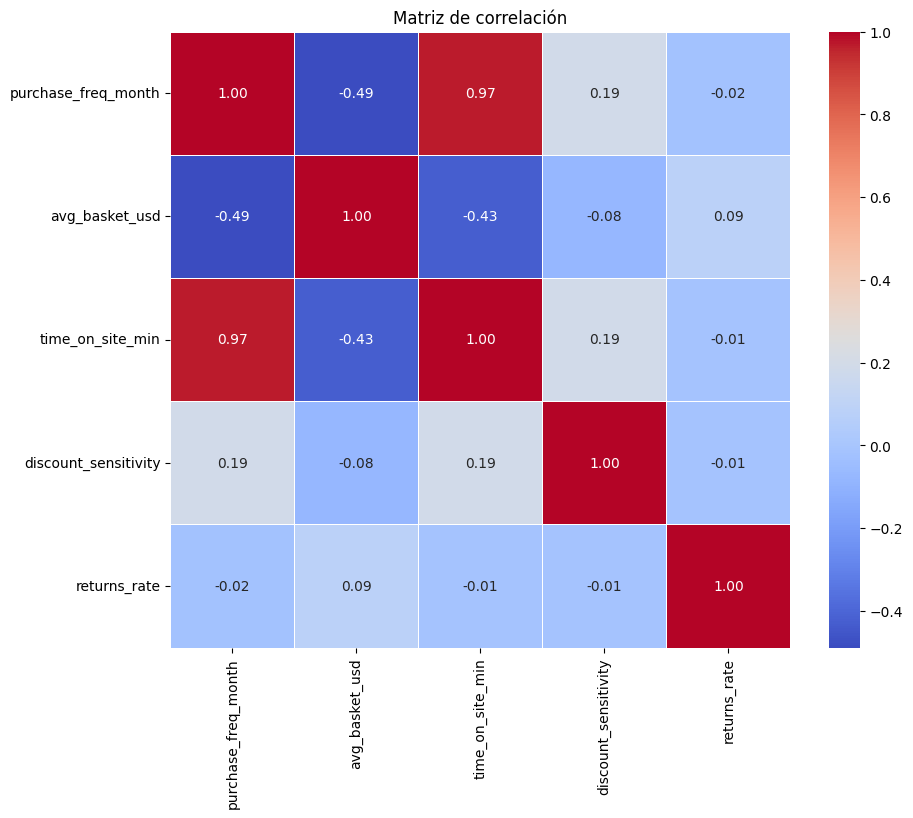

In [117]:
# Matriz de correlacion
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()


In [118]:
# Diccionario con nombres legibles
nombres = {
    'purchase_freq_month': 'Frecuencia de compras por mes',
    'avg_basket_usd': 'Ticket promedio por compra (USD)',
    'time_on_site_min': 'Tiempo de permanencia (minutos)',
    'discount_sensitivity': 'Sensibilidad a descuentos',
    'returns_rate': 'Tasa de devoluciones'
}


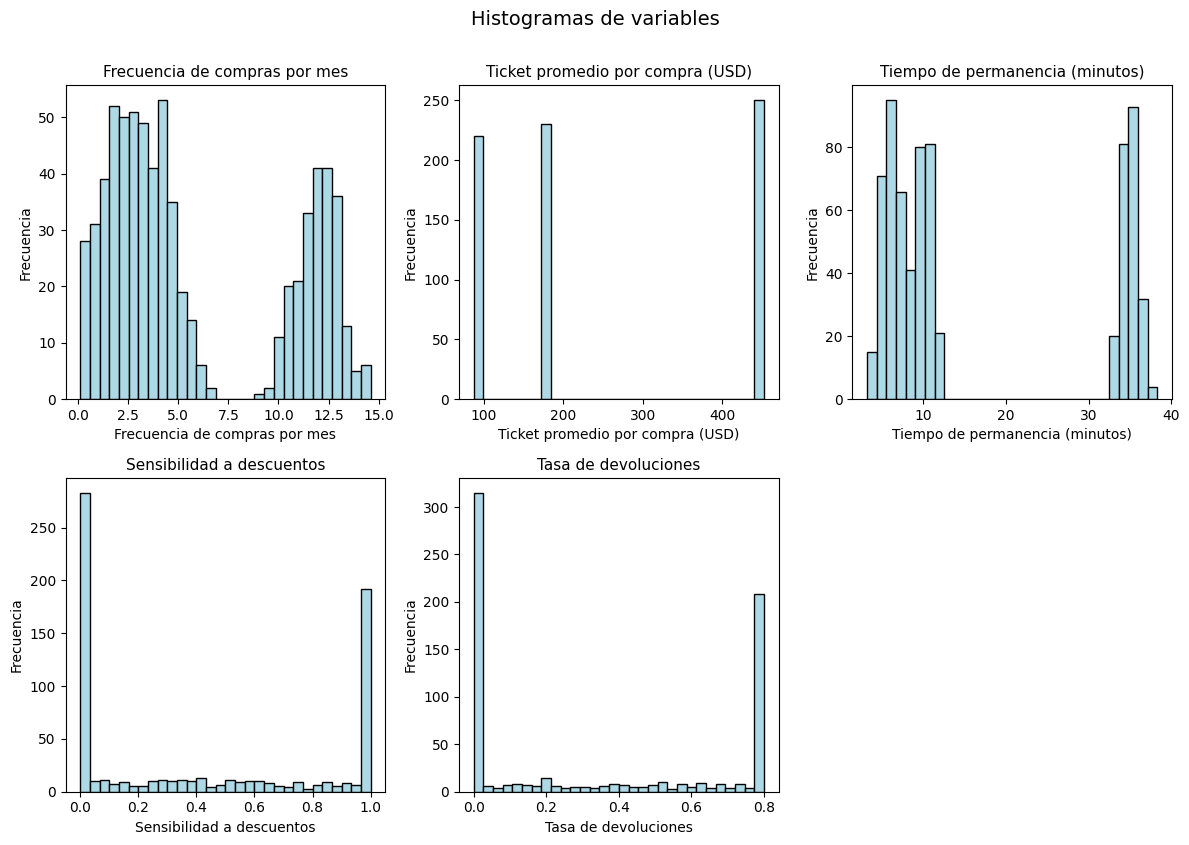

In [119]:
# Histograma por variable
plt.figure(figsize=(12, 8))

for i, col in enumerate(df.columns, 1):
    plt.subplot(2, 3, i)
    plt.hist(df[col], bins=30, color='lightblue', edgecolor='black')
    plt.title(nombres.get(col, col), fontsize=11)  # Usa el nombre legible si existe
    plt.xlabel(nombres.get(col, col))
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.suptitle("Histogramas de variables", fontsize=14, y=1.05)
plt.show()


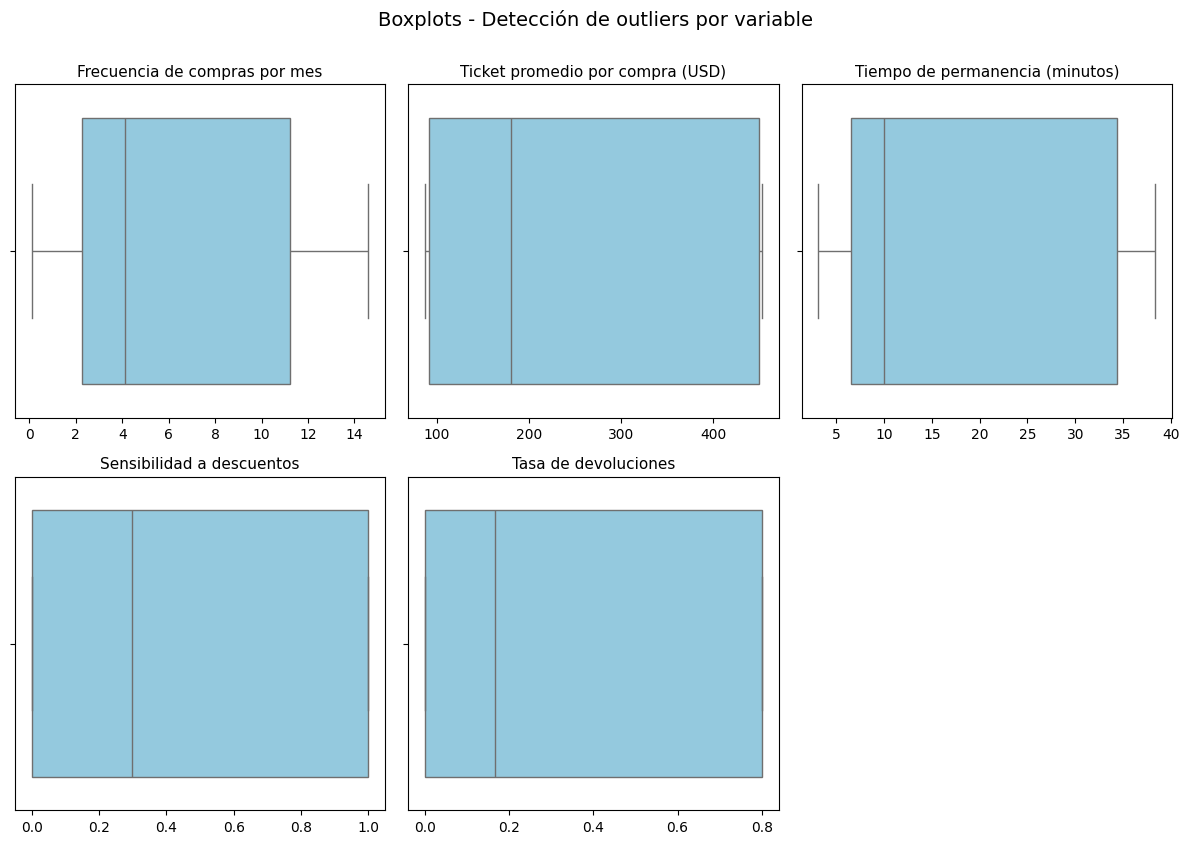

In [120]:
# Box-plot por variable
plt.figure(figsize=(12, 8))

for i, col in enumerate(df.columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(nombres.get(col, col), fontsize=11)
    plt.xlabel('')  # sin etiqueta en el eje X para limpieza
    plt.ylabel('')  # opcional, podés quitarlo si preferís

plt.tight_layout()
plt.suptitle('Boxplots - Detección de outliers por variable', fontsize=14, y=1.05)
plt.show()

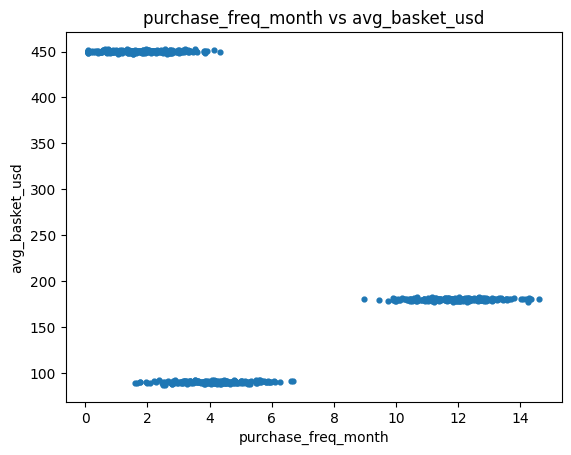

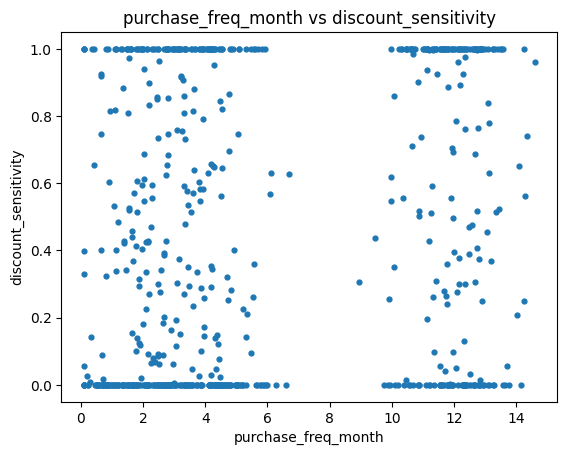

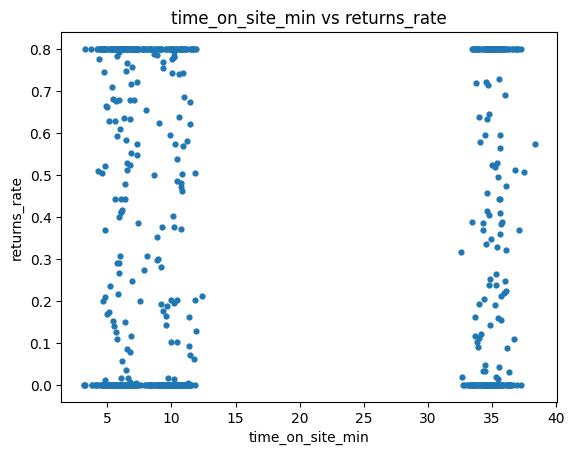

In [121]:
# Dispersión de algunas combinaciones útiles
pairs = [
    ("purchase_freq_month", "avg_basket_usd"), # Clientes muy valiosos: compran seguido y gastan mucho.
    ("purchase_freq_month", "discount_sensitivity"),
    ("time_on_site_min", "returns_rate")
]
for xcol, ycol in pairs:
    plt.figure()
    plt.scatter(df[xcol], df[ycol], s=12)
    plt.title(f"{xcol} vs {ycol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()


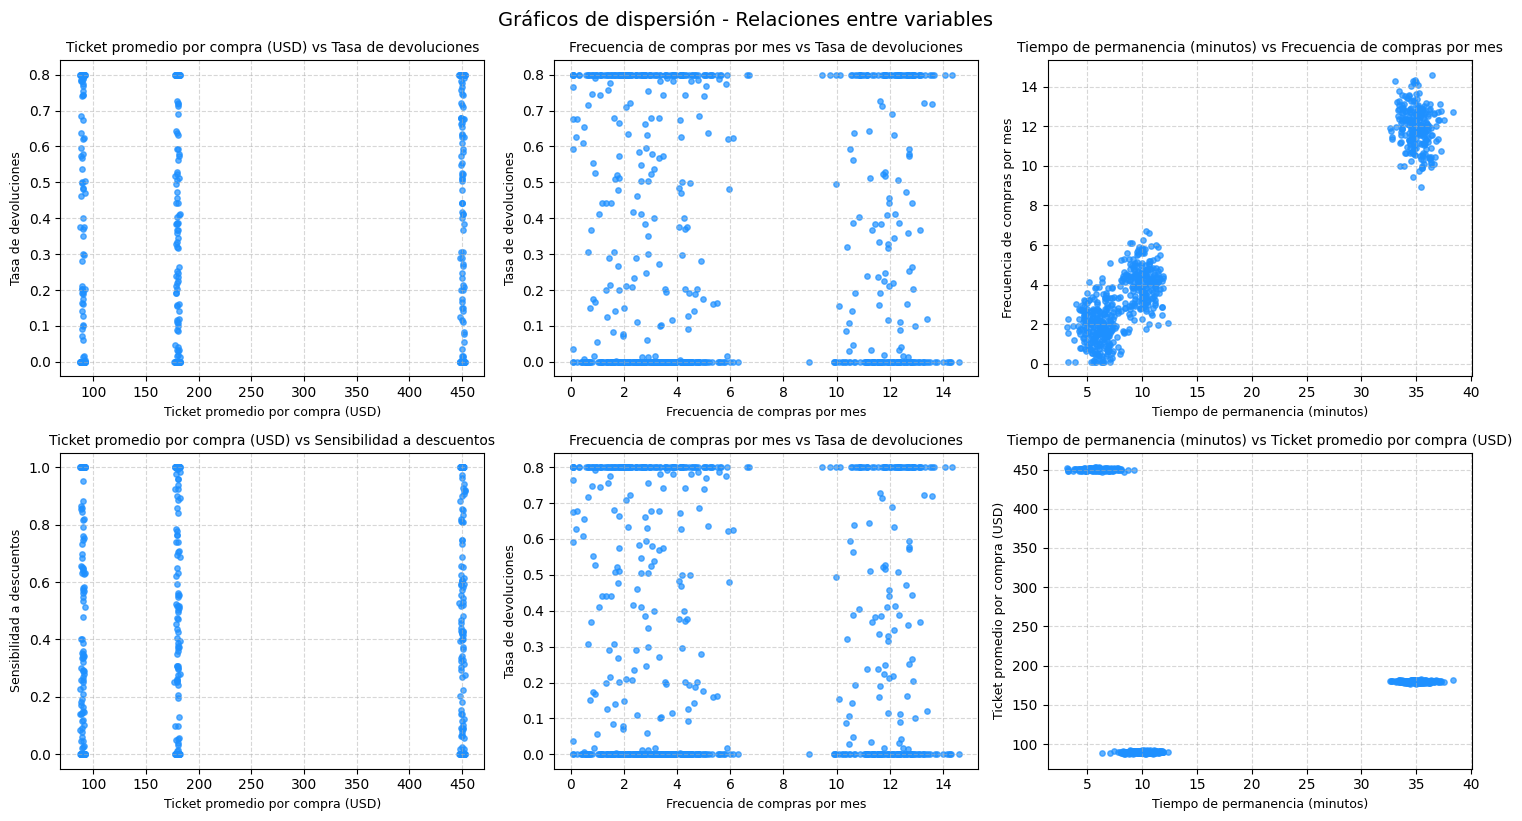

In [122]:
# Otras combinaciones posiblemente utiles.

# Pares de variables
pairs = [
    ("avg_basket_usd", "returns_rate"),          # Clientes problemáticos o indecisos
    ("purchase_freq_month", "returns_rate"),     # Clientes problemáticos o indecisos
    ("time_on_site_min", "purchase_freq_month"), # Exploran mucho, quizá comparan precios o no compran
    ("avg_basket_usd", "discount_sensitivity"),  # Compradores estratégicos que aprovechan promociones grandes
    ("purchase_freq_month", "returns_rate"),     # Compradores confiables y esporádicos
    ("time_on_site_min", "avg_basket_usd")       # Clientes que pasan mucho tiempo y compran más (o menos)
]

# Configurar el grid de subplots (2x3)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()  # Para iterar fácilmente

# Graficar cada par
for i, (xcol, ycol) in enumerate(pairs):
    ax = axes[i]
    ax.scatter(df[xcol], df[ycol], s=15, alpha=0.7, color='dodgerblue')
    ax.set_title(f"{nombres.get(xcol, xcol)} vs {nombres.get(ycol, ycol)}", fontsize=10)
    ax.set_xlabel(nombres.get(xcol, xcol), fontsize=9)
    ax.set_ylabel(nombres.get(ycol, ycol), fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.5)

# Ajustar el diseño
plt.tight_layout()
plt.suptitle("Gráficos de dispersión - Relaciones entre variables", fontsize=14, y=1.02)
plt.show()



## 3) Preparación: **escalado** de variables

K-Means utiliza distancia euclídea y es **sensible a la escala**.  
- Si existen **outliers**, `RobustScaler` suele ser más estable.  
- Si las distribuciones son razonables, `StandardScaler` funciona bien.




### Aquí probamos con `RobustScaler` (robusto a valores extremos). Podés cambiar a `StandardScaler()` si lo preferís.

In [123]:
# Elegí el escalador: RobustScaler o StandardScaler
scaler = RobustScaler()
X = scaler.fit_transform(df.values)
print("Forma de X (escalada):", X.shape)

Forma de X (escalada): (700, 5)



## 4) Seleccion del mejor **k = 2 .. 6** con **codo** (inercia) y **silhouette**


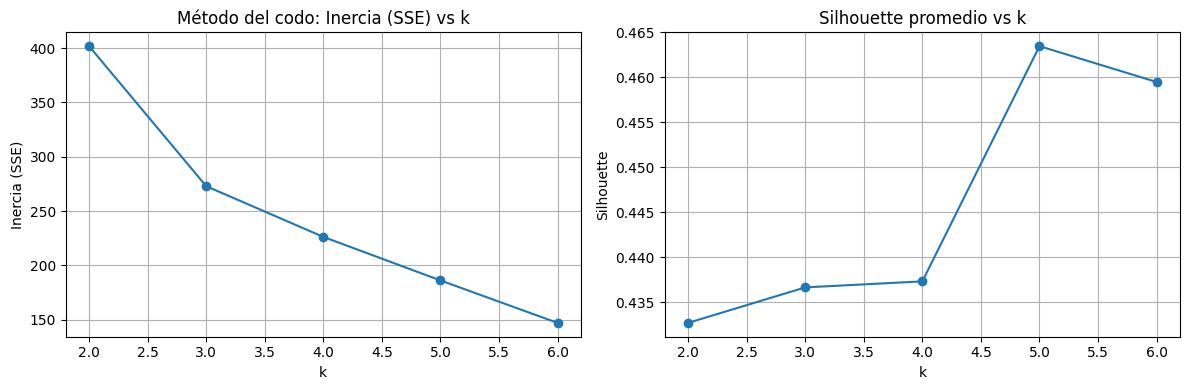

k recomendado por silhouette: 5
k=2: silhouette=0.4327
k=3: silhouette=0.4367
k=4: silhouette=0.4373
k=5: silhouette=0.4635
k=6: silhouette=0.4595


In [143]:
ks = range(2, 7)
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(
        n_clusters=k,
        init='k-means++', #Estrategia de inicialización que elige centroides "bien espaciados" para acelerar la convergencia y evitar malas soluciones por arranques aleatorios.
        # init='random', #También podemos pasar 'random', una matriz con centros iniciales o un callable.
        n_init=20, #Número de reinicios independientes (con distintas semillas de centroides). El modelo corre 20 veces y se queda con la mejor inercia
        max_iter=500, #Tope de iteraciones de Lloyd por cada reinicio. Si antes ya cumple el criterio de convergencia, corta antes
        tol=1e-4, #Tolerancia relativa para declarar convergencia, medida sobre la norma de Frobenius del cambio en los centros entre dos iteraciones. Más chico ⇒ más estricto (posibles más iteraciones).
        random_state=42,
        algorithm='lloyd' #Variante clásica EM-style de k-means. Alternativa: 'elkan', que usa la desigualdad triangular para saltarse cálculos y puede ser más rápido cuando hay clusters bien separados, a costa de más memoria
                      #algorithm='elkan' si los datos son densos, con clusters definidos y queremos más velocidad
    )
    labels = km.fit_predict(X)
    inertias.append(km.inertia_) #La inertia en K-Means es la suma de las distancias euclidianas al cuadrado de cada muestra a su centroide más cercano. Cuanto menor, mejor (clusters más compactos).
    silhouettes.append(silhouette_score(X, labels))


# Gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(list(ks), inertias, marker='o')
ax1.set_title("Método del codo: Inercia (SSE) vs k")
ax1.set_xlabel("k")
ax1.set_ylabel("Inercia (SSE)")
ax1.grid(True)

ax2.plot(list(ks), silhouettes, marker='o')
ax2.set_title("Silhouette promedio vs k")
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Elección automática basada en silhouette
best_k = ks[int(np.argmax(silhouettes))]


print("k recomendado por silhouette:", best_k)
for k, s in zip(ks, silhouettes):
    print(f"k={k}: silhouette={s:.4f}")


Diferencias clave

**Qué miden:**

  - Inertia: solo cohesión (compactación).

  - Silhouette: cohesión + separación entre clústeres.



## 5) Entrenamiento final con el **k** recomendado y análisis de centroides


In [125]:
k_final = int(best_k)
kmeans = KMeans(
    n_clusters=k_final,
    init='k-means++',
    n_init=50,
    max_iter=800,
    tol=1e-4,
    random_state=42,
    algorithm='lloyd'
)
labels = kmeans.fit_predict(X)
centers_scaled = kmeans.cluster_centers_

# Convertimos centroides al espacio original para interpretar
centers_original = pd.DataFrame(
    data=scaler.inverse_transform(centers_scaled),
    columns=df.columns
)

df_clusters = df.copy()
df_clusters["cluster"] = labels

display(centers_original.round(3))
display(df_clusters.head())

print("Inercia (SSE):", kmeans.inertia_, "| Iteraciones:", kmeans.n_iter_)
unique, counts = np.unique(labels, return_counts=True)
print("Tamaño de clusters:", dict(zip(unique, counts)))

,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate
0,11.961,179.999,35.022,0.542,0.332
1,1.886,450.208,5.887,0.358,0.041
2,4.225,89.876,10.053,0.347,0.732
3,1.805,450.034,6.067,0.358,0.732
4,4.010,90.008,9.974,0.399,0.031


,purchase_freq_month,avg_basket_usd,time_on_site_min,discount_sensitivity,returns_rate,cluster
0,11.152508,181.300834,33.564036,1.000000,0.800000,0
1,12.053451,178.637272,35.432081,0.784974,0.000000,0
2,2.203006,450.185298,7.030757,0.898297,0.000000,1
3,4.233314,89.006342,10.834453,0.000000,0.800000,2
4,1.716799,449.773982,7.254548,0.000000,0.003279,1


Inercia (SSE): 186.23337102782617 | Iteraciones: 4
Tamaño de clusters: {np.int32(0): np.int64(230), np.int32(1): np.int64(129), np.int32(2): np.int64(84), np.int32(3): np.int64(121), np.int32(4): np.int64(136)}



## 6) Visualización 2D con **PCA** y fronteras aproximadas


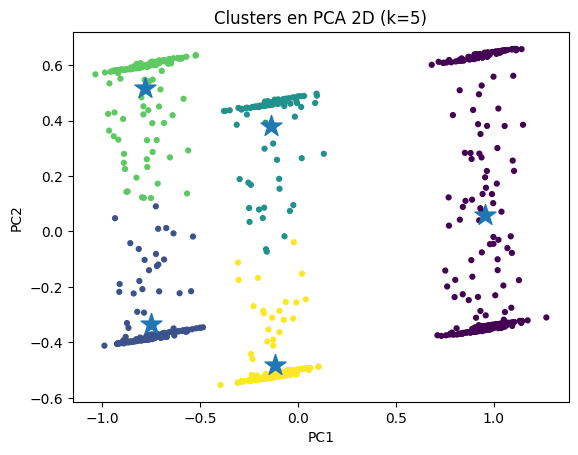

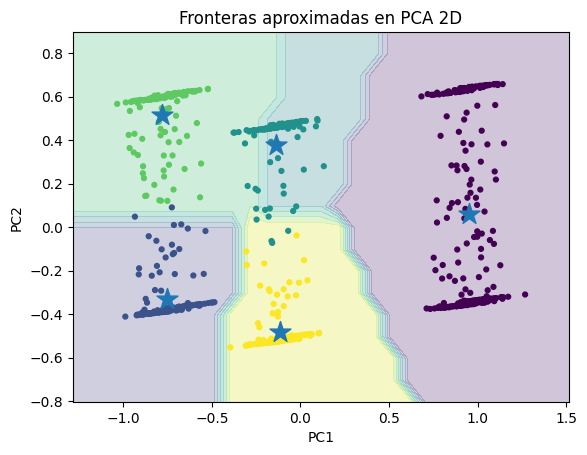

In [126]:
# Reducimos a 2D para graficar
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)
centers_2d = pca.transform(centers_scaled)

# Puntos por cluster
plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=12)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='*', s=250)
plt.title(f"Clusters en PCA 2D (k={k_final})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Fronteras aproximadas sobre la proyección 2D (estimativa)
h = 0.1
x_min, x_max = X_2d[:, 0].min() - 0.25, X_2d[:, 0].max() + 0.25
y_min, y_max = X_2d[:, 1].min() - 0.25, X_2d[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_2d = np.c_[xx.ravel(), yy.ravel()]

# Aproximamos predicción en la proyección: transformamos grid inversamente a PCA
# NOTA: Esta aproximación usa un truco: llevamos grid_2d a espacio escalado asumiendo componente nula fuera de las 2 PCs
# para poder usar el modelo, lo cual es sólo una visualización aproximada.
# The inverse transform should be applied to the 2D grid directly
grid_scaled = pca.inverse_transform(grid_2d)  # Corrected: inverse transform applied to grid_2d
Z = kmeans.predict(grid_scaled).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.25)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=12)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='*', s=250)
plt.title("Fronteras aproximadas en PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 7) Perfiles de clusters interpretables

Compararemos cada centroide contra cuartiles del dataset original para etiquetar rasgos **Altos/Medios/Bajos** por variable y generar descripciones.


In [127]:
q = df.quantile([0.25, 0.5, 0.75])
q1, q2, q3 = q.loc[0.25], q.loc[0.5], q.loc[0.75]

def tag_level(val, col):
    if val <= q1[col]: return "bajo"
    if val >= q3[col]: return "alto"
    return "medio"

profiles = []
for i, row in centers_original.iterrows():
    desc = []
    for col in df.columns:
        desc.append(f"{col}: {tag_level(row[col], col)} ({row[col]:.2f})")
    profiles.append((i, "; ".join(desc)))

for cid, txt in profiles:
    print(f"Cluster {cid}: {txt}")


Cluster 0: purchase_freq_month: alto (11.96); avg_basket_usd: medio (180.00); time_on_site_min: alto (35.02); discount_sensitivity: medio (0.54); returns_rate: medio (0.33)
Cluster 1: purchase_freq_month: bajo (1.89); avg_basket_usd: alto (450.21); time_on_site_min: bajo (5.89); discount_sensitivity: medio (0.36); returns_rate: medio (0.04)
Cluster 2: purchase_freq_month: medio (4.23); avg_basket_usd: bajo (89.88); time_on_site_min: medio (10.05); discount_sensitivity: medio (0.35); returns_rate: medio (0.73)
Cluster 3: purchase_freq_month: bajo (1.80); avg_basket_usd: alto (450.03); time_on_site_min: bajo (6.07); discount_sensitivity: medio (0.36); returns_rate: medio (0.73)
Cluster 4: purchase_freq_month: medio (4.01); avg_basket_usd: bajo (90.01); time_on_site_min: medio (9.97); discount_sensitivity: medio (0.40); returns_rate: medio (0.03)


| **Cluster** | **Tipo de Cliente**     | **Frecuencia de Compra (mensual)** | **Ticket Promedio (USD)** | **Tiempo en Sitio (min)** | **Tasa de Devolución** | **Comportamiento Clave**                                       | **Estrategia Sugerida**                                                                |
| ----------- | ----------------------- | ---------------------------------- | ------------------------- | ------------------------- | ---------------------- | -------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| **0**       | Enganchado y recurrente | **Alta (11.96)**                   | **Medio (180.00)**        | **Alta (35.02)**          | **Media (0.33)**       | Clientes muy activos, visitan y compran seguido.               | Programas de fidelización o recomendaciones personalizadas              |
| **1**       | Premium ocasional       | **Baja (1.89)**                    | **Alta (450.21)**         | **Baja (5.89)**           | **Media-baja (0.04)**  | Compran poco pero gastan mucho, valoran calidad y simplicidad. | Experiencias premium, early access, marketing exclusivo.                               |
| **2**       | Buscador de ofertas     | **Media (4.23)**                   | **Bajo (89.88)**          | **Media (10.05)**         | **Alta (0.73)**        | Compradores sensibles al precio, con devoluciones frecuentes.  | Promociones controladas, mejorar descripción y talles, políticas de devolución claras. |
| **3**       | Premium indeciso        | **Baja (1.80)**                    | **Alta (450.03)**         | **Baja (6.07)**           | **Alta (0.73)**        | Gastan mucho pero devuelven seguido, compran con inseguridad.  | Atención postventa personalizada, soporte rápido, mejoras visuales en productos.       |
| **4**       | Moderado estable        | **Media (4.01)**                   | **Bajo (90.01)**          | **Media (9.97)**          | **Baja (0.03)**        | Compradores estables y predecibles, sin excesos ni problemas.  | Incentivar recompra gradual, descuentos por recurrencia, comunicación neutra.          |


# Variaciones del Modelo propuesto **escalado con `StandardScaler`**


## 3) Preparación: **escalado** con `StandardScaler`


In [128]:
# Elegí el escalador: RobustScaler o StandardScaler
scalerStandar = StandardScaler ()
XStandar = scalerStandar.fit_transform(df.values)


## 4) Seleccion del **k = 2..6** con **codo** (inercia) y **silhouette**


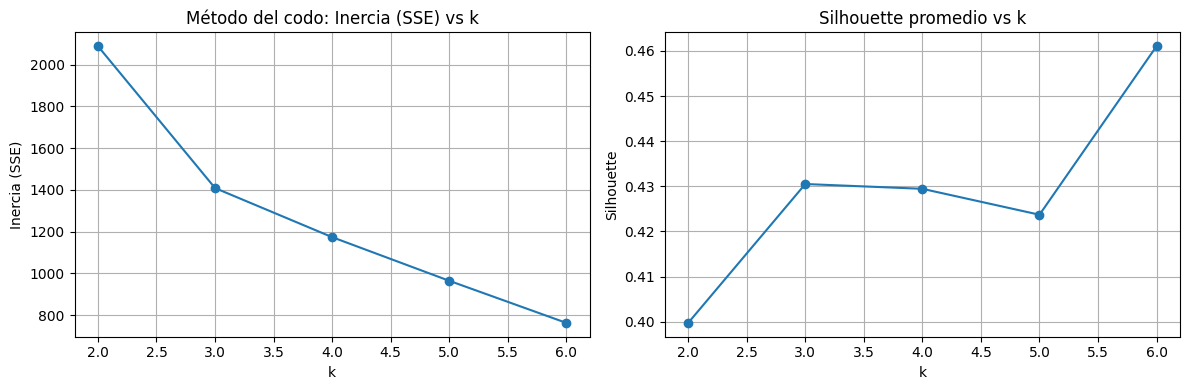

k recomendado por silhouette: 6
k=2: silhouette=0.3997
k=3: silhouette=0.4305
k=4: silhouette=0.4295
k=5: silhouette=0.4237
k=6: silhouette=0.4610


In [129]:
ks = range(2, 7)
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=20,
        max_iter=500,
        tol=1e-4,
        random_state=42,
        algorithm='lloyd'
    )
    labels = km.fit_predict(XStandar)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(XStandar, labels))


# Gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(list(ks), inertias, marker='o')
ax1.set_title("Método del codo: Inercia (SSE) vs k")
ax1.set_xlabel("k")
ax1.set_ylabel("Inercia (SSE)")
ax1.grid(True)

ax2.plot(list(ks), silhouettes, marker='o')
ax2.set_title("Silhouette promedio vs k")
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Elección automática basada en silhouette
best_kXStandar = ks[int(np.argmax(silhouettes))]


print("k recomendado por silhouette:", best_kXStandar)
for k, s in zip(ks, silhouettes):
    print(f"k={k}: silhouette={s:.4f}")


## 5) Entrenamiento final con el **k** recomendado y análisis de centroides


In [130]:
k_finalXStandar = int(best_kXStandar)
kmeansXStandar = KMeans(
    n_clusters=k_finalXStandar,
    init='k-means++',
    n_init=50,
    max_iter=800,
    tol=1e-4,
    random_state=42,
    algorithm='lloyd'
)
labels = kmeansXStandar.fit_predict(X)
centers_scaled = kmeansXStandar.cluster_centers_

# Convertimos centroides al espacio original para interpretar
centers_originalXStandar = pd.DataFrame(
    data=scaler.inverse_transform(centers_scaled),
    columns=df.columns
)

df_clustersXStandar = df.copy()
df_clustersXStandar["cluster"] = labels


## 6) Visualización 2D con **PCA** y fronteras aproximadas


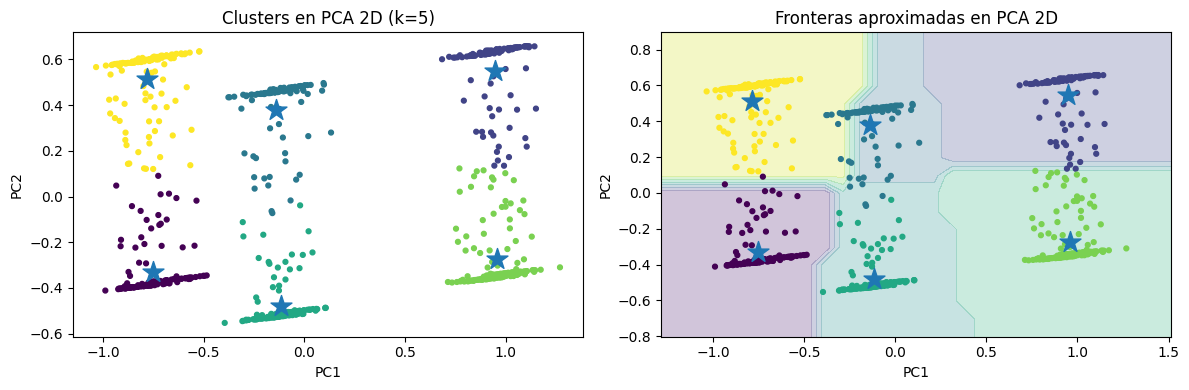

In [131]:
# Reducimos a 2D para graficar
pcaXStandar = PCA(n_components=2, random_state=42)
X_2dXStandar = pcaXStandar.fit_transform(X)
centers_2dXStandar = pcaXStandar.transform(centers_scaled)

# Gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Puntos por cluster
ax1.scatter(X_2dXStandar[:, 0], X_2dXStandar[:, 1], c=labels, s=12)
ax1.scatter(centers_2dXStandar[:, 0], centers_2dXStandar[:, 1], marker='*', s=250)
ax1.set_title(f"Clusters en PCA 2D (k={k_final})")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

# Fronteras aproximadas sobre la proyección 2D (estimativa)
h = 0.1
x_min, x_max = X_2dXStandar[:, 0].min() - 0.25, X_2dXStandar[:, 0].max() + 0.25
y_min, y_max = X_2dXStandar[:, 1].min() - 0.25, X_2dXStandar[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_2dXStandar = np.c_[xx.ravel(), yy.ravel()]

grid_scaledXStandar = pcaXStandar.inverse_transform(grid_2dXStandar)
Z = kmeansXStandar.predict(grid_scaledXStandar).reshape(xx.shape)

ax2.contourf(xx, yy, Z, alpha=0.25)
ax2.scatter(X_2dXStandar[:, 0], X_2dXStandar[:, 1], c=labels, s=12)
ax2.scatter(centers_2dXStandar[:, 0], centers_2dXStandar[:, 1], marker='*', s=250)
ax2.set_title("Fronteras aproximadas en PCA 2D")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
plt.show()


## 7) Perfiles de clusters interpretables


In [132]:
q = df.quantile([0.25, 0.5, 0.75])
q1, q2, q3 = q.loc[0.25], q.loc[0.5], q.loc[0.75]

def tag_level(val, col):
    if val <= q1[col]: return "bajo"
    if val >= q3[col]: return "alto"
    return "medio"

profiles = []
for i, row in centers_originalXStandar.iterrows():
    desc = []
    for col in df.columns:
        desc.append(f"{col}: {tag_level(row[col], col)} ({row[col]:.2f})")
    profiles.append((i, "; ".join(desc)))

for cid, txt in profiles:
    print(f"Cluster {cid}: {txt}")


Cluster 0: purchase_freq_month: bajo (1.89); avg_basket_usd: alto (450.21); time_on_site_min: bajo (5.89); discount_sensitivity: medio (0.36); returns_rate: medio (0.04)
Cluster 1: purchase_freq_month: alto (12.00); avg_basket_usd: medio (179.97); time_on_site_min: alto (35.20); discount_sensitivity: medio (0.57); returns_rate: medio (0.73)
Cluster 2: purchase_freq_month: medio (4.23); avg_basket_usd: bajo (89.88); time_on_site_min: medio (10.05); discount_sensitivity: medio (0.35); returns_rate: medio (0.73)
Cluster 3: purchase_freq_month: medio (4.01); avg_basket_usd: bajo (90.01); time_on_site_min: medio (9.97); discount_sensitivity: medio (0.40); returns_rate: medio (0.03)
Cluster 4: purchase_freq_month: alto (11.94); avg_basket_usd: medio (180.02); time_on_site_min: alto (34.90); discount_sensitivity: medio (0.52); returns_rate: medio (0.06)
Cluster 5: purchase_freq_month: bajo (1.80); avg_basket_usd: alto (450.03); time_on_site_min: bajo (6.07); discount_sensitivity: medio (0.36)

| **Cluster** | **Tipo de Cliente**            | **Frecuencia de Compra (mensual)** | **Ticket Promedio (USD)** | **Tiempo en Sitio (min)** | **Tasa de Devolución** | **Comportamiento Clave**                                            | **Estrategia Sugerida**                                                            |
| ----------- | ------------------------------ | ---------------------------------- | ------------------------- | ------------------------- | ---------------------- | ------------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **0**       | **Premium ocasional**          | **Baja (1.89)**                    | **Alta (450.21)**         | **Baja (5.89)**           | **Baja (0.04)**        | Compran poco pero gastan mucho; son decididos y valoran calidad.    | Ofrecer productos exclusivos, early access, upselling premium.                     |
| **1**       | **Explorador impulsivo**       | **Alta (12.00)**                   | **Media (179.97)**        | **Alta (35.20)**          | **Alta (0.73)**        | Muy activos y curiosos; compran seguido pero devuelven mucho.       | Revisar información de productos, mejorar guías/talles y simplificar devoluciones. |
| **2**       | **Cazador de ofertas**         | **Media (4.23)**                   | **Baja (89.88)**          | **Media (10.05)**         | **Alta (0.73)**        | Compran por precio, suelen arrepentirse o dudar.                    | Promos controladas, comunicación clara, reforzar confianza postcompra.             |
| **3**       | **Cliente estable**            | **Media (4.01)**                   | **Baja (90.01)**          | **Media (9.97)**          | **Baja (0.03)**        | Regular, sin grandes picos ni devoluciones.                         | Fomentar lealtad con descuentos por recurrencia o puntos de fidelización.          |
| **4**       | **Comprador fiel y eficiente** | **Alta (11.94)**                   | **Media (180.02)**        | **Alta (34.90)**          | **Baja (0.06)**        | Compradores frecuentes y satisfechos, devuelven poco.               | Mantener fidelidad, ofrecer bundles o programas VIP.                               |
| **5**       | **Premium indeciso**           | **Baja (1.80)**                    | **Alta (450.03)**         | **Baja (6.07)**           | **Alta (0.73)**        | Gastan mucho pero devuelven con frecuencia; dudan antes de decidir. | Mejorar confianza visual (reseñas, fotos, video), soporte preventa personalizado.  |



| Tipo de cambio         | Cluster | Qué cambió                                                                |
| ---------------------- | ------- | ------------------------------------------------------------------------- |
| Nuevo               | 5       | “Premium indeciso” (baja frecuencia, ticket alto, devoluciones altas)     |
| Redefinido          | 1       | De medio a muy alto en frecuencia y devoluciones → “Explorador impulsivo” |
| Reforzado           | 4       | Más fiel y estable, ahora con devoluciones mínimas                        |
| Sin cambios significativos | 0, 2, 3 | Mantienen esencia, solo ajustes leves en interpretación                   |


# Variaciones del Modelo **K = 2 .. 7**


## 3) Preparación: **escalado** de variables `RobustScaler`

In [133]:
# Elegí el escalador: RobustScaler o StandardScaler
scaler = RobustScaler ()
X = scaler.fit_transform(df.values)


## 4) Seleccion del **k = 2..7** con **codo** (inercia) y **silhouette**


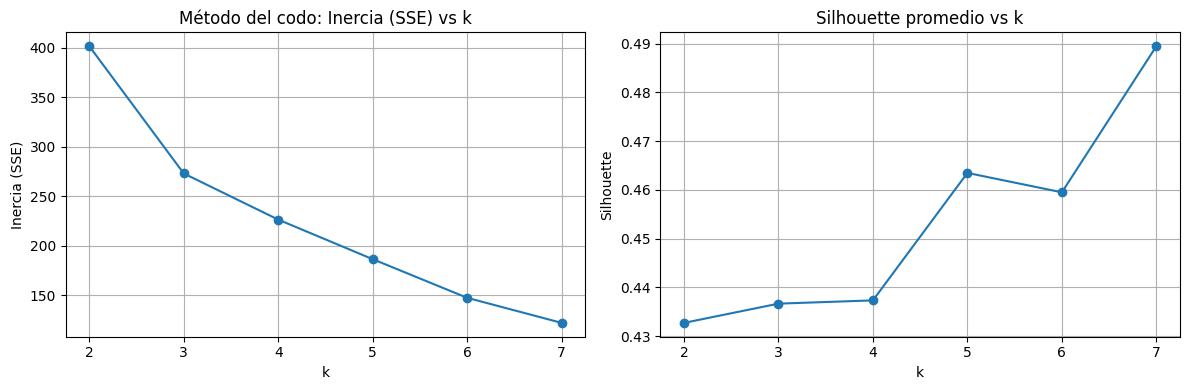

k recomendado por silhouette: 7
k=2: silhouette=0.4327
k=3: silhouette=0.4367
k=4: silhouette=0.4373
k=5: silhouette=0.4635
k=6: silhouette=0.4595
k=7: silhouette=0.4895


In [134]:
ks = range(2, 8)
inertias, silhouettes = [], []

for k in ks:
    km = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=20,
        max_iter=500,
        tol=1e-4,
        random_state=42,
        algorithm='lloyd'
    )
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))


# Gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(list(ks), inertias, marker='o')
ax1.set_title("Método del codo: Inercia (SSE) vs k")
ax1.set_xlabel("k")
ax1.set_ylabel("Inercia (SSE)")
ax1.grid(True)

ax2.plot(list(ks), silhouettes, marker='o')
ax2.set_title("Silhouette promedio vs k")
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Elección automática basada en silhouette
best_k = ks[int(np.argmax(silhouettes))]


print("k recomendado por silhouette:", best_k)
for k, s in zip(ks, silhouettes):
    print(f"k={k}: silhouette={s:.4f}")


## 5) Entrenamiento final con el **k** recomendado y análisis de centroides


In [135]:
k_final = int(best_k)
kmeans = KMeans(
    n_clusters=k_final,
    init='k-means++',
    n_init=50,
    max_iter=800,
    tol=1e-4,
    random_state=42,
    algorithm='lloyd'
)
labels = kmeans.fit_predict(X)
centers_scaled = kmeans.cluster_centers_

# Convertimos centroides al espacio original para interpretar
centers_original = pd.DataFrame(
    data=scaler.inverse_transform(centers_scaled),
    columns=df.columns
)

df_clusters = df.copy()
df_clusters["cluster"] = labels



## 6) Visualización 2D con **PCA** y fronteras aproximadas


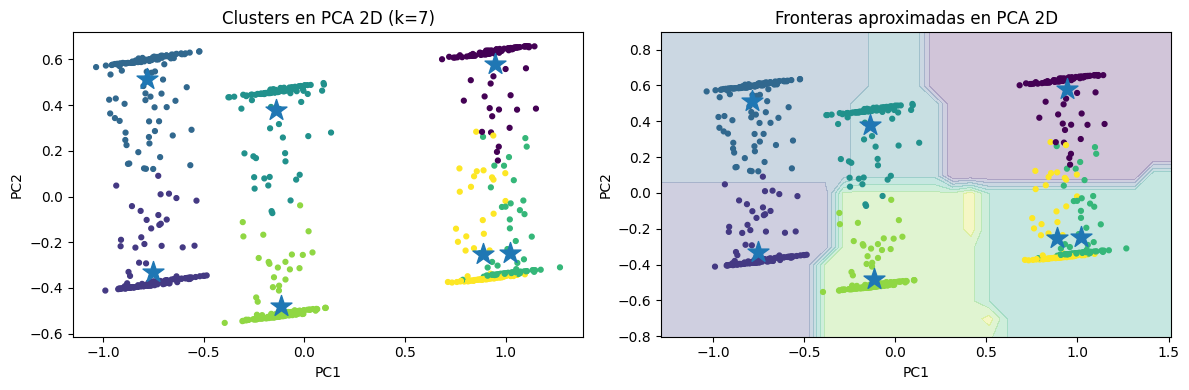

In [136]:
# Reducimos a 2D para graficar
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)
centers_2d = pca.transform(centers_scaled)

# Gráficos lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Puntos por cluster
ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=12)
ax1.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='*', s=250)
ax1.set_title(f"Clusters en PCA 2D (k={k_final})")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")

# Fronteras aproximadas sobre la proyección 2D (estimativa)
h = 0.1
x_min, x_max = X_2d[:, 0].min() - 0.25, X_2d[:, 0].max() + 0.25
y_min, y_max = X_2d[:, 1].min() - 0.25, X_2d[:, 1].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_2d = np.c_[xx.ravel(), yy.ravel()]

grid_scaled = pca.inverse_transform(grid_2d)
Z = kmeans.predict(grid_scaled).reshape(xx.shape)

ax2.contourf(xx, yy, Z, alpha=0.25)
ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=12)
ax2.scatter(centers_2d[:, 0], centers_2d[:, 1], marker='*', s=250)
ax2.set_title("Fronteras aproximadas en PCA 2D")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
plt.show()


## 7) Perfiles de clusters interpretables


In [137]:
q = df.quantile([0.25, 0.5, 0.75])
q1, q2, q3 = q.loc[0.25], q.loc[0.5], q.loc[0.75]

def tag_level(val, col):
    if val <= q1[col]: return "bajo"
    if val >= q3[col]: return "alto"
    return "medio"

profiles = []
for i, row in centers_original.iterrows():
    desc = []
    for col in df.columns:
        desc.append(f"{col}: {tag_level(row[col], col)} ({row[col]:.2f})")
    profiles.append((i, "; ".join(desc)))

for cid, txt in profiles:
    print(f"Cluster {cid}: {txt}")


Cluster 0: purchase_freq_month: alto (12.02); avg_basket_usd: medio (180.01); time_on_site_min: alto (35.16); discount_sensitivity: medio (0.55); returns_rate: medio (0.75)
Cluster 1: purchase_freq_month: bajo (1.89); avg_basket_usd: alto (450.21); time_on_site_min: bajo (5.89); discount_sensitivity: medio (0.36); returns_rate: medio (0.04)
Cluster 2: purchase_freq_month: bajo (1.80); avg_basket_usd: alto (450.03); time_on_site_min: bajo (6.07); discount_sensitivity: medio (0.36); returns_rate: medio (0.73)
Cluster 3: purchase_freq_month: medio (4.23); avg_basket_usd: bajo (89.88); time_on_site_min: medio (10.05); discount_sensitivity: medio (0.35); returns_rate: medio (0.73)
Cluster 4: purchase_freq_month: alto (11.90); avg_basket_usd: medio (180.05); time_on_site_min: alto (34.84); discount_sensitivity: medio (0.93); returns_rate: medio (0.07)
Cluster 5: purchase_freq_month: medio (4.01); avg_basket_usd: bajo (90.01); time_on_site_min: medio (9.97); discount_sensitivity: medio (0.40)

| **Cluster** | **Tipo de cliente**               | **Frecuencia de compra** | **Ticket promedio (USD)** | **Tiempo en el sitio (min)** | **Sensibilidad a descuentos** | **Tasa de devolución** | **Descripción del comportamiento**                                                                              | **Sugerencia de acción**                                                                         |
| :---------: | :-------------------------------- | :----------------------- | :------------------------ | :--------------------------- | :---------------------------- | :--------------------- | :-------------------------------------------------------------------------------------------------------------- | :----------------------------------------------------------------------------------------------- |
|    **0**    | **Explorador impulsivo**          | Alta (≈12)               | Media (≈180)              | Alta (≈35)                   | Media (0.55)                  | Alta (0.75)            | Navega mucho, compra seguido pero devuelve bastante. Posible indecisión o falta de satisfacción post-compra.    | Mejorar experiencia de compra, calidad de productos y políticas de devolución. Analizar reseñas. |
|    **1**    | **Premium estable**               | Baja (≈1.9)              | Alta (≈450)               | Baja (≈6)                    | Media (0.36)                  | Baja (0.04)            | Compras esporádicas, alto poder adquisitivo, casi sin devoluciones.                                             | Estrategias de **fidelización VIP**, preventas, exclusividad.                                    |
|    **2**    | **Premium indeciso**              | Baja (≈1.8)              | Alta (≈450)               | Baja (≈6)                    | Media (0.36)                  | Alta (0.73)            | Compras grandes, pero devuelve mucho. Puede ser exigente o insatisfecho con la experiencia.                     | Comunicación personalizada y seguimiento postventa. Mejorar información de producto.             |
|    **3**    | **Cazador de ofertas indeciso**   | Media (≈4.2)             | Baja (≈90)                | Media (≈10)                  | Media (0.35)                  | Alta (0.73)            | Compra por promociones, pero se arrepiente o encuentra fallas.                                                  | Revisar segmentación de descuentos, garantizar calidad o precisión en talles.                    |
|    **4**    | **Oportunista racional**          | Alta (≈11.9)             | Media (≈180)              | Alta (≈35)                   | Muy alta (0.93)               | Baja (0.07)            | Compra mucho y responde fuertemente a descuentos, pero devuelve poco. Cliente muy rentable si se gestiona bien. | Enfocar en **campañas promocionales dirigidas** y **programas de lealtad**.                      |
|    **5**    | **Comprador eficiente y estable** | Media (≈4.0)             | Baja (≈90)                | Media (≈10)                  | Media (0.40)                  | Muy baja (0.03)        | Cliente moderado y confiable, sin complicaciones.                                                               | Mantener con comunicación simple y beneficios por recurrencia.                                   |
|    **6**    | **Leal indiferente a descuentos** | Alta (≈12)               | Media (≈180)              | Alta (≈35)                   | Muy baja (0.08)               | Baja (0.09)            | Compra seguido sin necesitar promociones. Poco propenso a devolver. Cliente ideal.                              | Recompensar lealtad con experiencias exclusivas, recomendaciones personalizadas.                 |


Observaciones generales:

Hay tres grupos (Clusters 0, 4, 6) de alta frecuencia, tickets altos, y mucha permanencia con diferencias en sensibilidad a descuentos:

- 0 → indeciso (muchas devoluciones),
- 4 → impulsado por descuentos,
- 6 → fiel sin incentivos.

Dos grupos premium (1 y 2) muestran contrastes fuertes en devoluciones.

Los clusters 3 y 5 son de perfil medio, más homogéneos y estables